In [154]:
import numpy as np
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

In [155]:
data = pd.read_csv("task_dataset - training_dataset.csv")

print("Shape of dataset:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nSample rows:")
display(data.head())


Shape of dataset: (8936, 2)

Columns: ['property_address', 'categories']

Sample rows:


,property_address,categories
0,"New Ppid 1Kqttmg7, House, Property Id No.58C57...",houseorplot
1,"Property Of Rs No.12/2,Plot No. 01,House Numbe...",houseorplot
2,"Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9...",flat
3,"Flat-103,Floor-1 Eshamya Florenza Tower L S No...",flat
4,Flat No G 532 I P Extension Patparganj 2Nd Flo...,flat


In [156]:
print("\nCategory distribution:")
print(data["categories"].value_counts())


Category distribution:
categories
flat               3232
houseorplot        2673
others             1197
commercial unit     965
landparcel          869
Name: count, dtype: int64


In [157]:
print("\nMissing values (%):")
print(data.isna().mean() * 100)


Missing values (%):
property_address   0.00
categories         0.00
dtype: float64


In [158]:
data = data.dropna(subset=["property_address", "categories"]).reset_index(drop=True)
print("\nShape after dropping missing:", data.shape)


Shape after dropping missing: (8936, 2)


In [159]:
RANDOM_STATE = 42
train_data, temp_data = train_test_split(
    data,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=data["categories"],
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=temp_data["categories"],
)

In [160]:
print("\nSplit sizes:")
print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))


Split sizes:
Train: 7148
Validation: 894
Test: 894


In [161]:
print("\nTrain category distribution:")
print(train_data["categories"].value_counts(normalize=False))



Train category distribution:
categories
flat               2585
houseorplot        2138
others              958
commercial unit     772
landparcel          695
Name: count, dtype: int64


In [162]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [163]:
for df in (train_data, val_data, test_data):
    df["clean_address"] = df["property_address"].apply(clean_text)

print("\nSample cleaned addresses:")
for i in range(3):
    print("Original:", train_data["property_address"].iloc[i])
    print("Cleaned :", train_data["clean_address"].iloc[i])
    print("-" * 60)


Sample cleaned addresses:
Original: Unit-233A Bhagwati Nagar First S No Kartarpura,Near Maheshnagar Jaipur 302015 Rajasthan
Cleaned : unit 233a bhagwati nagar first s no kartarpura near maheshnagar jaipur 302015 rajasthan
------------------------------------------------------------
Original: Shop No 45 Gopalpura By Pass Jaipur-302020 New Atish Market Near Ganga Jamuna Petrol Pump
Cleaned : shop no 45 gopalpura by pass jaipur 302020 new atish market near ganga jamuna petrol pump
------------------------------------------------------------
Original: Western Half Portion Of Plot No.24, Western Half Portion Of Plot No.24, Balabhaupeth Nagarik Gruhnirman Sahakari Sansthaltd. Nagpur,, Kh No.89,, Sheet No.259/85, Cts No.298, Mouja Dabha,, Tah & Dist. Nagpur. 440023, Wardha, Ph No.07, Nagpur, Maharashtra, India, 442001
Cleaned : western half portion of plot no 24 western half portion of plot no 24 balabhaupeth nagarik gruhnirman sahakari sansthaltd nagpur kh no 89 sheet no 259 85 cts no 298 m

In [164]:
vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2), 
)

X_train = vectorizer.fit_transform(train_data["clean_address"])
X_val = vectorizer.transform(val_data["clean_address"])
X_test = vectorizer.transform(test_data["clean_address"])

y_train = train_data["categories"].values
y_val = val_data["categories"].values
y_test = test_data["categories"].values

print("\nTF-IDF feature size:", len(vectorizer.get_feature_names_out()))



TF-IDF feature size: 2000


In [165]:
# Save vectorizer artifact
joblib.dump(vectorizer, "artifacts/vectorizer.pkl")

['artifacts/vectorizer.pkl']

In [166]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "MultinomialNB": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE,
    ),
}

In [167]:
results = []

print("\nTraining & evaluating models on validation set...\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    
    acc = accuracy_score(y_val, val_preds)
    f1_macro = f1_score(y_val, val_preds, average="macro")
    f1_weighted = f1_score(y_val, val_preds, average="weighted")
    
    results.append([name, acc, f1_macro, f1_weighted])
    print(f"{name}:")
    print(f"  Accuracy     : {acc:.4f}")
    print(f"  F1 (macro)   : {f1_macro:.4f}")
    print(f"  F1 (weighted): {f1_weighted:.4f}\n")


Training & evaluating models on validation set...

Logistic Regression:
  Accuracy     : 0.8647
  F1 (macro)   : 0.8419
  F1 (weighted): 0.8637

MultinomialNB:
  Accuracy     : 0.7595
  F1 (macro)   : 0.7151
  F1 (weighted): 0.7470

Linear SVM:
  Accuracy     : 0.8691
  F1 (macro)   : 0.8521
  F1 (weighted): 0.8695

Random Forest:
  Accuracy     : 0.9161
  F1 (macro)   : 0.9036
  F1 (weighted): 0.9170



In [168]:
results_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "Macro F1", "Weighted F1"]
).sort_values(by="Accuracy", ascending=False)

print("\nValidation results:")
display(results_df)


Validation results:


,Model,Accuracy,Macro F1,Weighted F1
3,Random Forest,0.92,0.90,0.92
2,Linear SVM,0.87,0.85,0.87
0,Logistic Regression,0.86,0.84,0.86
1,MultinomialNB,0.76,0.72,0.75


In [169]:
best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model on validation set: {best_model_name}")

best_model = models[best_model_name]


Best model on validation set: Random Forest


In [170]:
import scipy.sparse as sp

X_final_train = sp.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

print("\nTraining best model on Train + Val...")
best_model.fit(X_final_train, y_final_train)


Training best model on Train + Val...


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [171]:
print("\n=== Test Evaluation ===")
test_preds = best_model.predict(X_test)

test_acc = accuracy_score(y_test, test_preds)
test_f1_macro = f1_score(y_test, test_preds, average="macro")
test_f1_weighted = f1_score(y_test, test_preds, average="weighted")
test_precision_macro = precision_score(y_test, test_preds, average="macro")
test_recall_macro = recall_score(y_test, test_preds, average="macro")

print(f"Test Accuracy        : {test_acc:.4f}")
print(f"Test Macro F1        : {test_f1_macro:.4f}")
print(f"Test Weighted F1     : {test_f1_weighted:.4f}")
print(f"Test Macro Precision : {test_precision_macro:.4f}")
print(f"Test Macro Recall    : {test_recall_macro:.4f}")

print("\nClassification report (per class):")
print(classification_report(y_test, test_preds))


=== Test Evaluation ===
Test Accuracy        : 0.9105
Test Macro F1        : 0.8927
Test Weighted F1     : 0.9096
Test Macro Precision : 0.9048
Test Macro Recall    : 0.8850

Classification report (per class):
                 precision    recall  f1-score   support

commercial unit       1.00      0.94      0.97        97
           flat       0.95      0.95      0.95       323
    houseorplot       0.88      0.91      0.90       268
     landparcel       0.85      0.69      0.76        87
         others       0.85      0.93      0.89       119

       accuracy                           0.91       894
      macro avg       0.90      0.89      0.89       894
   weighted avg       0.91      0.91      0.91       894



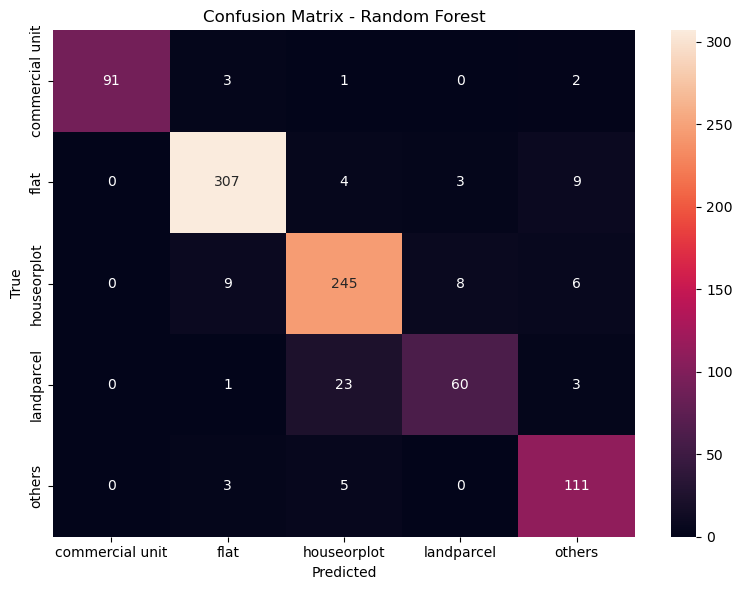

In [172]:
labels = sorted(data["categories"].unique())
cm = confusion_matrix(y_test, test_preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.savefig("artifacts/confusion_matrix.png", dpi=200)
plt.show()

In [173]:
joblib.dump(best_model, "artifacts/best_model.pkl")
joblib.dump(vectorizer, "artifacts/vectorizer.pkl")  # re-save to be sure
print("\nSaved model and vectorizer to 'artifacts/' folder.")


Saved model and vectorizer to 'artifacts/' folder.


In [174]:
def predict_category(address: str) -> str:
    """
    Predict category for a single property address string.
    """
    cleaned = clean_text(address)
    vec = vectorizer.transform([cleaned])
    pred = best_model.predict(vec)[0]
    return pred

In [175]:
examples = [
    "Flat No 203, Tower B, Sector 76, Noida",
    "Plot No. 55, Near Mandir, Jaipur Rajasthan",
    "Survey No 77/2, Near Highway, Open Land, Gujarat",
    "Shop No 10, Ground Floor, Commercial Complex, Mumbai",
]

print("\nSanity check predictions:")
for e in examples:
    print(f"Text: {e}")
    print("Pred:", predict_category(e))
    print("-" * 40)


Sanity check predictions:
Text: Flat No 203, Tower B, Sector 76, Noida
Pred: flat
----------------------------------------
Text: Plot No. 55, Near Mandir, Jaipur Rajasthan
Pred: houseorplot
----------------------------------------
Text: Survey No 77/2, Near Highway, Open Land, Gujarat
Pred: landparcel
----------------------------------------
Text: Shop No 10, Ground Floor, Commercial Complex, Mumbai
Pred: commercial unit
----------------------------------------


In [176]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
}


In [177]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=30,             
    cv=3,                 
    scoring="f1_macro",   
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [178]:
print("Best Score:", random_search.best_score_)
print("Best Params:")
for k,v in random_search.best_params_.items():
    print(f"  {k}: {v}")


Best Score: 0.8841626475561973
Best Params:
  n_estimators: 500
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None
  bootstrap: False


In [ ]:
best_rf = RandomForestClassifier(
    **random_search.best_params_,
    random_state=42,
    n_jobs=-1
)

import scipy.sparse as sp

X_final_train = sp.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

best_rf.fit(X_final_train, y_final_train)


RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [180]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

test_preds = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Macro F1:", f1_score(y_test, test_preds, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, test_preds))


Test Accuracy: 0.9217002237136466
Test Macro F1: 0.9080294456152513

Classification Report:
                  precision    recall  f1-score   support

commercial unit       0.99      0.96      0.97        97
           flat       0.96      0.96      0.96       323
    houseorplot       0.88      0.92      0.90       268
     landparcel       0.88      0.74      0.80        87
         others       0.89      0.92      0.91       119

       accuracy                           0.92       894
      macro avg       0.92      0.90      0.91       894
   weighted avg       0.92      0.92      0.92       894



In [181]:
joblib.dump(best_rf, "artifacts/final_rf_model.pkl")

['artifacts/final_rf_model.pkl']